# *K-Nearest Neighbors Classification for Higgs Signal vs. Background*

ELEFTHERIOS MARIOS ZOGRAFOS\
AEM : 4428

### *1. Importing Libraries*

> ***Note***: This algorithm utilizes parallel processing routines that depend on the `joblib` module. Please ensure that this module is installed on your system. If not, execute the code block below first. You may need to restart the kernel after installation.

In [1]:
# %pip install joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

### _2. The K - Nearest Neighbors function_

1. **Splitting the Data into Training and Test Sets**
   - Use the `train_test_split` function from `scikit-learn` to divide the dataset into _**training**_ and _**test**_ sets.
   - Adjust the `test_size` parameter to control the proportion of data allocated for testing.
   - Optionally, set `random_state` for reproducibility.
2. **Scaling the Data**
   - Use a `scaler` from `scikit-learn` to apply "_**Z-score standardization**_" to the data.
 
$$ x' = (x-μ)/ σ  $$

In [3]:
def scale_sets(X: np.ndarray, y: np.ndarray, test_size: float = 0.25, random_state: int = 32) -> tuple:
    """
    Split features X and labels y into stratified training and test sets,
    then apply Z-score standardization to both.
    """

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

3. **Creating the _Classifier_**

   - Define a `param_grid` variable with possible values for the _number of neighbors_.
   
   - Implement a cross-validation technique with parallel processing to determine the optimal number of neighbors based on the dataset's AUC score.
   
     > ***Note:***
     > 1. By default, `n_jobs` is set to `-1` to utilize all available processors. Adjust this value if background processes are running concurrently.
     > 2. The _**cross-validation**_ employs a _5-fold_ approach and evaluates up to _**250**_ neighbors. Modify these parameters based on system capabilities and dataset characteristics.
     

In [4]:
def get_classifier(X_train: np.ndarray, y_train: np.ndarray, n_jobs: int = -1, max_neighbors: int = 250) :
    """
    Build and tune a KNN classifier via GridSearchCV (5-fold CV,
    optimizing ROC AUC) over n_neighbors from 1 to max_neighbors-1.
    """
    param_grid = {'n_neighbors': np.arange(1, max_neighbors)}
    knn = KNeighborsClassifier()
    with parallel_backend('loky', n_jobs=n_jobs):
        grid = GridSearchCV(
            knn,
            param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=n_jobs
        )
        grid.fit(X_train, y_train)
    return grid

4. **Drawing the Confusion Matrix**

   Use the classifier's best parameters, determined earlier, to make predictions on the test set and display the confusion matrix.


In [5]:
def plot_confusion(clf: GridSearchCV, X_test: np.ndarray, y_test: np.ndarray, title: str):
    """
    Plot a standalone confusion matrix at threshold 0.5.
    """
    y_pred = clf.best_estimator_.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix - {title}')
    fig.tight_layout()
    plt.show()
    return y_pred

5. **Drawing the Model's _ROC_ Curve & Calculating the Model's _Parameters_ and _Accuracy_**

In [6]:
def plot_roc_and_stats(clf: GridSearchCV, X_test: np.ndarray, y_test: np.ndarray, title: str) -> dict:
    """
    Plot a standalone ROC curve, compute and return AUC and accuracy.
    """
    y_prob = clf.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
    ax.set_title(f'ROC Curve - {title}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    fig.tight_layout()
    plt.show()
    return {
        'AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, (y_prob > 0.5).astype(int))
    }

### ***Results***

1. **Loading the Data**

   - First, load the data into a DataFrame.
   
     > **_Note:_** The dataset contains instances of `e+00.1`, which Python does not recognize as numeric values by default. To prevent errors, these values must be modified as shown below.


In [7]:
df = pd.read_csv('HIGGS_8K.csv', header=None)\
    .replace(to_replace=r'[eE]\+?\d+\.\d+', value=0, regex=True)\
    .astype(np.float64)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.0,1.630428,0.404143,0.401026,2.722409,0.355644,1.362199,0.015818,-1.174111,0.000000,...,0.387635,1.596321,1.550981,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,1.0,0.326305,-0.797735,0.223471,1.248234,-1.427857,0.923767,-0.278280,-0.470052,0.000000,...,-0.426866,1.153501,0.000000,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627
3,1.0,1.381170,0.521993,0.574698,0.357347,0.037136,0.413057,-0.607036,-1.308270,0.000000,...,0.567525,-1.475778,0.000000,0.936186,1.107217,0.983808,0.693327,0.562045,0.825387,0.846233
4,1.0,0.304161,-0.736375,0.686225,0.477172,-1.274736,0.907003,0.324770,-0.463954,2.173076,...,0.904818,1.165154,0.000000,1.181790,1.033701,0.993943,0.648399,0.936097,0.732592,0.661779


2. **Execute the KNN Analysis**
      
     > _e.g._, on an _Intel(R) Core(TM) i7-8750H @ 2.2GHz_, setting the number of neighbors to check to 1000 takes approximately _15 minutes_.

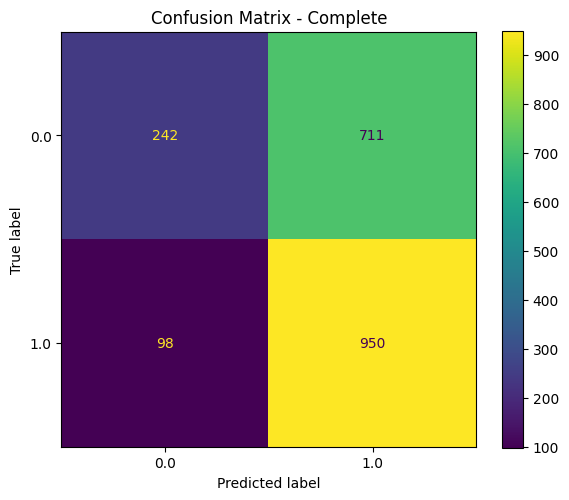

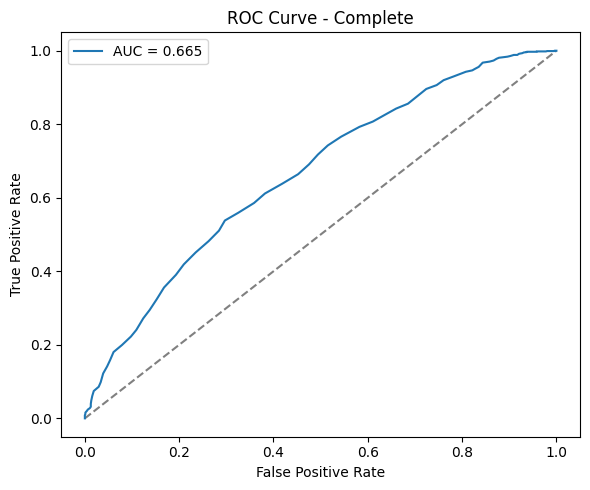

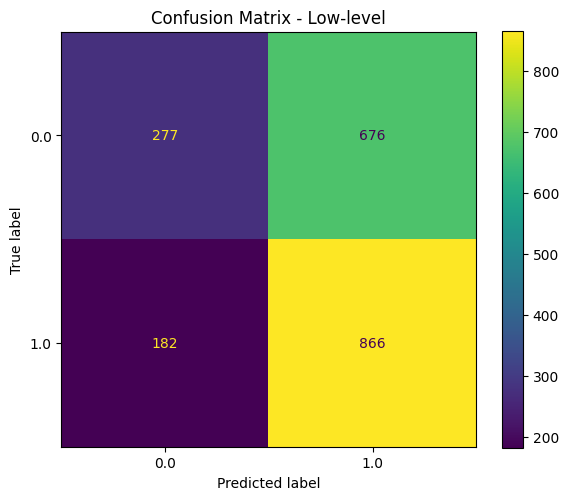

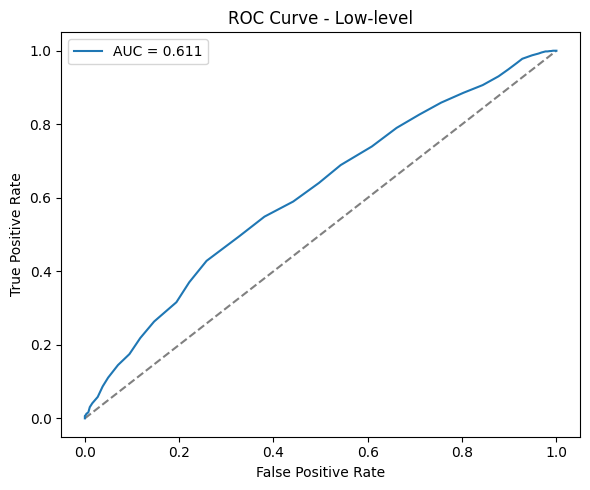

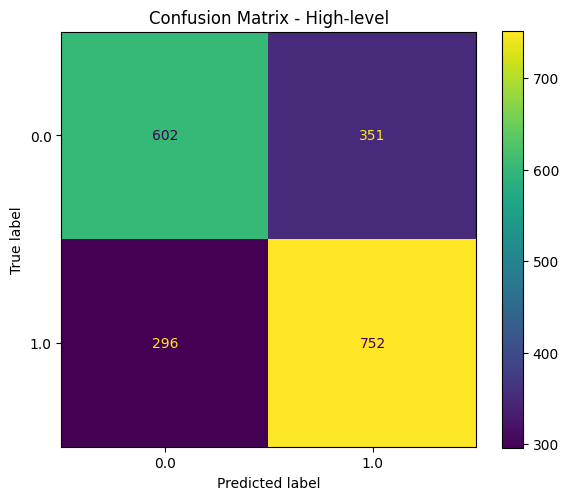

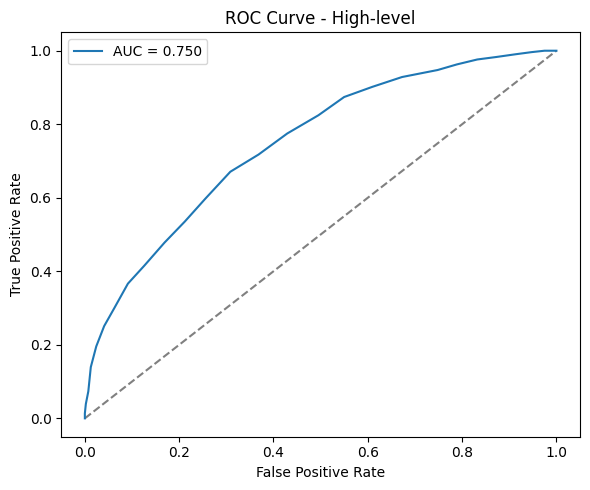

,AUC,Accuracy,Best n_neighbors
Complete,0.664528,0.595702,228.0
Low-level,0.611272,0.571214,103.0
High-level,0.749686,0.676662,27.0


In [8]:
y = df.iloc[:, 0]
X_all   = df.iloc[:, 1:]
X_low   = df.iloc[:, 1:22]
X_high  = df.iloc[:, 22:]
feature_sets = {'Complete': X_all, 'Low-level': X_low, 'High-level': X_high}

results = {}
for label, X in feature_sets.items():
    # Split, scale, and train
    X_train, X_test, y_train, y_test = scale_sets(X, y)
    clf = get_classifier(X_train, y_train,)
    # Plot confusion matrix and ROC separately
    _ = plot_confusion(clf, X_test, y_test, label)
    stats = plot_roc_and_stats(clf, X_test, y_test, label)
    stats['Best n_neighbors'] = clf.best_params_['n_neighbors']
    results[label] = stats

# Summarize Results
results_df = pd.DataFrame(results).T
results_df